In [1]:
import sys
sys.path.append('../../')

In [65]:
from codes.docs.analysis import data_preprocessing, MLtraining
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
european_diffusion_dataset_term=pd.read_csv('./preprocessed_data/diffusion/term/european_diffusion_dataset_term.csv')

In [4]:
feature_column_names=european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'].columns

Dividing the dataset into high and low risk using the PRS scores, thresholded at 0.05.

In [5]:
#preprocess the PRS score
PRS_thresholds=['PRS_1e08', 'PRS_1e07', 'PRS_1e06', 'PRS_1e05', 'PRS_0.0001','PRS_0.001', 'PRS_0.01', 'PRS_0.05', 'PRS_0.1', 'PRS_0.5', 'PRS_1']
# PRS_thresholds=['PRS_0.05']

adjusted_prs_score=data_preprocessing.adjusting_for_covariates_with_lin_reg(np.array(european_diffusion_dataset_term['PRS_0.05']),
np.array(european_diffusion_dataset_term['Anc_PC1']),np.array(european_diffusion_dataset_term['Anc_PC2']),np.array(european_diffusion_dataset_term['Anc_PC3']))

Train model on the bottom 40% (low risk) and perform PRS correlation on the top 20% (high risk)

In [72]:
high_risk,low_risk=data_preprocessing.high_low_risk_divide(adjusted_prs_score,high_perc=0.2,low_perc=0.4)

In [73]:
y_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,'PMA_diff'])

In [74]:
X_total=np.asarray(european_diffusion_dataset_term.loc[:,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])
X_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])
X_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,'PreCG.R_PreCG.L':'ITG.R_ITG.L'])


y_total=np.asarray(european_diffusion_dataset_term['PMA_diff'])
y_low_risk=np.asarray(european_diffusion_dataset_term.loc[low_risk,'PMA_diff'])
y_high_risk=np.asarray(european_diffusion_dataset_term.loc[high_risk,'PMA_diff'])

In [75]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
import time

In [77]:
#Perform Retain_non_zero_features, and correlated features to prs_score from the low_risk dataset
start=time.time()
pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features()),
('remove_correlation',MLtraining.High_Corr_Remover(target=adjusted_prs_score[low_risk],average=True))])
X_low_risk_after_pipe0=pipe0.fit_transform(X_low_risk)
X_high_risk_after_pipe0=pipe0.transform(X_high_risk)
print(time.time()-start)
#Training the PMA prediction model on the transformed low_risk dataset
data_splitting=MLtraining.splitting_dataset_into_k_fold(X_low_risk_after_pipe0,y_low_risk,k=3)
result={}
y_high_risk_pred_dict={}
for i in tqdm.tqdm(range(3)):
    X_trainval, y_trainval, X_test, y_test=next(data_splitting)
    inner_cv=KFold(n_splits=3)
    regr=RidgeCV(cv=inner_cv)#find the best_hyperparameter
    pipe1=Pipeline([('scaler', MinMaxScaler()),('regr',regr)])
    pipe1.fit(X_trainval,y_trainval)
    bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,pipe1.predict(X_trainval))
    y_pred=pipe1.predict(X_test)#model performance on low risk
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=MLtraining.print_scores(y_pred,y_test)

    #use the trained model to predict the brain age (PMA at scan) for high risk subject
    y_high_risk_pred=pipe1.predict(X_high_risk_after_pipe0)
    y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    y_high_risk_pred_dict[i]=y_high_risk_pred

100%|██████████| 3/3 [00:00<00:00, 30.86it/s]38.46189308166504



In [78]:
PMA_result=pd.DataFrame(result).T
PMA_result.append(pd.DataFrame(PMA_result.mean(axis=0)).T,ignore_index=True)

,r2,MAE,MSE,Correlation,p_value
0,0.659010,0.676843,0.777071,0.855608,7.648361e-07
1,0.578204,1.007090,1.281743,0.798388,2.449084e-05
2,0.555089,0.717522,1.055619,0.754497,1.211378e-04
3,0.597434,0.800485,1.038144,0.802831,4.879782e-05


Text(0.5, 1.0, 'testing y_pred_bias vs y_true')

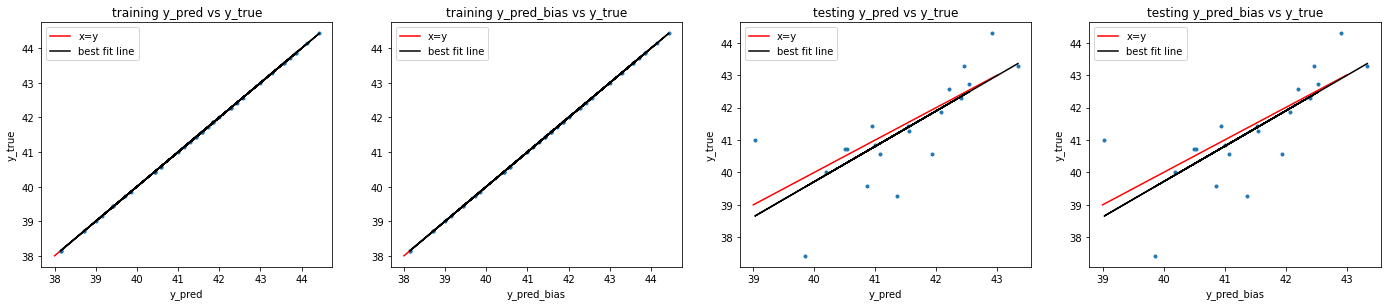

In [79]:
y_train_pred=pipe1.predict(X_trainval)
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4.5))
ax1.plot(y_train_pred,y_trainval,'.')
ax1.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred.reshape(-1,1),y_trainval)
ax1.plot(y_train_pred,lin_reg.predict(y_train_pred.reshape(-1,1)),'k-',label='best fit line')
ax1.set_ylabel('y_true')
ax1.set_xlabel('y_pred')
ax1.legend()
ax1.set_title('training y_pred vs y_true')

y_pred=pipe1.predict(X_test)
ax3.plot(y_pred,y_test,'.')
ax3.plot([39,43],[39,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
ax3.plot(y_pred,lin_reg.predict(y_pred.reshape(-1,1)),'k-',label='best fit line')
ax3.set_ylabel('y_true')
ax3.set_xlabel('y_pred')
ax3.legend()
ax3.set_title('testing y_pred vs y_true')


lin_reg_bias=LinearRegression()
coef,inter=MLtraining.get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_train_pred_bias,y_trainval,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(y_train_pred_bias,lin_reg.predict(y_train_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax2.set_xlabel('y_pred_bias')
ax2.legend()
ax2.set_title('training y_pred_bias vs y_true')

y_pred_bias=y_pred+y_pred*coef+inter
ax4.plot(y_pred_bias,y_test,'.')
ax4.plot([39,43],[39,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
ax4.plot(y_pred_bias,lin_reg.predict(y_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax4.set_ylabel('y_true')
ax4.set_xlabel('y_pred_bias')
ax4.legend()
ax4.set_title('testing y_pred_bias vs y_true')



In [80]:
brain_age_difference=pd.DataFrame(y_high_risk_pred_dict)
brain_age_difference['mean_PMA_pred']=brain_age_difference.mean(axis=1)
brain_age_difference['true_PMA_pred']=y_high_risk
brain_age_difference['residual']=brain_age_difference['mean_PMA_pred']-brain_age_difference['true_PMA_pred']

brain_age_difference

,0,1,2,mean_PMA_pred,true_PMA_pred,residual
0,42.807618,42.665832,42.459686,42.644378,44.428571,-1.784193
1,42.933391,43.457592,42.953628,43.114870,44.714286,-1.599415
2,42.007642,42.287666,42.218160,42.171156,43.571429,-1.400273
3,40.044558,40.577025,40.882069,40.501217,41.000000,-0.498783
4,40.994644,41.366394,41.197633,41.186223,42.714286,-1.528062
5,41.106104,41.714290,41.190176,41.336857,42.285714,-0.948858
6,41.550982,42.507949,41.549639,41.869524,44.000000,-2.130476
7,41.679095,41.900572,41.976534,41.852067,42.000000,-0.147933
8,41.704934,42.049834,41.803632,41.852800,42.142857,-0.290057
9,42.731027,43.058202,42.158379,42.649202,44.285714,-1.636512


In [81]:
brain_age_difference_corr=pd.DataFrame({'Correlation':(pearsonr(brain_age_difference['residual'],adjusted_prs_score[high_risk]))[0],
'p-value':(pearsonr(brain_age_difference['residual'],adjusted_prs_score[high_risk]))[1]},index=['PRS_0.05'])

brain_age_difference_corr

,Correlation,p-value
PRS_0.05,-0.625234,0.000169


Text(0, 0.5, 'brain age difference')

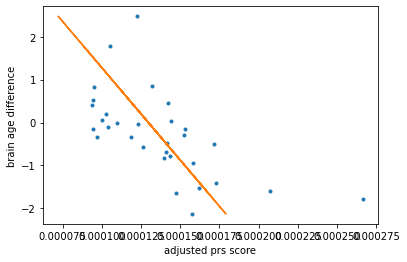

In [101]:
plt.plot(adjusted_prs_score[high_risk],brain_age_difference['residual'],'.')
lin_reg=LinearRegression()
lin_reg.fit(np.asarray(brain_age_difference['residual']).reshape(-1,1),adjusted_prs_score[high_risk])
plt.plot(lin_reg.predict(np.asarray(brain_age_difference['residual']).reshape(-1,1)),brain_age_difference['residual'])
plt.xlabel('adjusted prs score')
plt.ylabel('brain age difference')

In [102]:
#Perform Retain_non_zero_features, and correlated features to prs_score from the low_risk dataset
start=time.time()
pipe0=Pipeline([('remove_zeros',MLtraining.Retain_non_zero_features()),
('remove_correlation',MLtraining.High_Corr_Remover(target=adjusted_prs_score[low_risk],average=True))])
X_low_risk_after_pipe0=pipe0.fit_transform(X_low_risk)
X_high_risk_after_pipe0=pipe0.transform(X_high_risk)
print(time.time()-start)
#Training the PMA prediction model on the low_risk dataset
data_splitting=MLtraining.splitting_dataset_into_k_fold(X_low_risk_after_pipe0,y_low_risk,k=3)
result={}
y_high_risk_pred_dict={}
for i in tqdm.tqdm(range(3)):
    X_trainval, y_trainval, X_test, y_test=next(data_splitting)
    # inner_cv=KFold(n_splits=3)
    # regr=RidgeCV(cv=inner_cv)#find the best_hyperparameter
    regr=RandomForestRegressor(n_estimators=30,max_depth=250,bootstrap=True,oob_score=False)
    pipe1=Pipeline([('scaler', MinMaxScaler()),('regr',regr)])
    pipe1.fit(X_trainval,y_trainval)
    bias_coeff,bias_intercept=MLtraining.get_model_bias(y_trainval,pipe1.predict(X_trainval))
    y_pred=pipe1.predict(X_test)#model performance on low risk
    y_pred=y_pred+y_pred*bias_coeff+bias_intercept
    result[i]=MLtraining.print_scores(y_pred,y_test)

    #use the trained model to predict the brain age (PMA at scan) for high risk subject
    y_high_risk_pred=pipe1.predict(X_high_risk_after_pipe0)
    y_high_risk_pred=y_high_risk_pred+y_high_risk_pred*bias_coeff+bias_intercept
    y_high_risk_pred_dict[i]=y_high_risk_pred

100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Text(0.5, 1.0, 'testing y_pred_bias vs y_true')

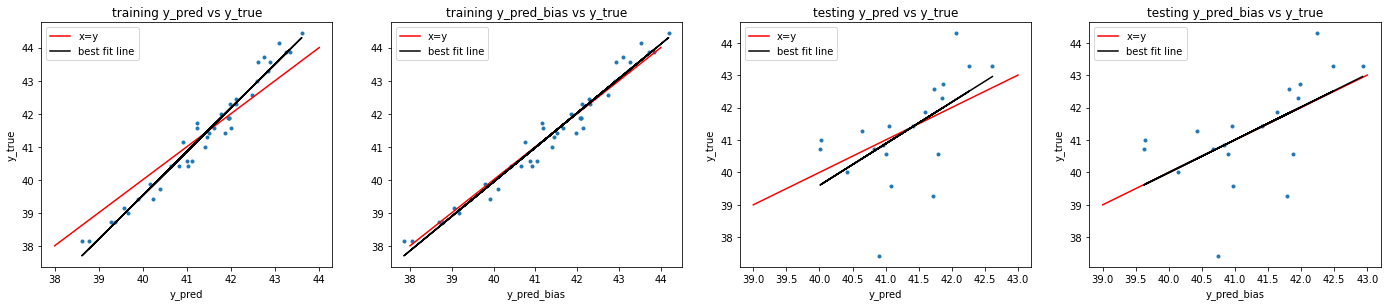

In [103]:
y_train_pred=pipe1.predict(X_trainval)
f,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(24,4.5))
ax1.plot(y_train_pred,y_trainval,'.')
ax1.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred.reshape(-1,1),y_trainval)
ax1.plot(y_train_pred,lin_reg.predict(y_train_pred.reshape(-1,1)),'k-',label='best fit line')
ax1.set_ylabel('y_true')
ax1.set_xlabel('y_pred')
ax1.legend()
ax1.set_title('training y_pred vs y_true')

y_pred=pipe1.predict(X_test)
ax3.plot(y_pred,y_test,'.')
ax3.plot([39,43],[39,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred.reshape(-1,1),y_test)
ax3.plot(y_pred,lin_reg.predict(y_pred.reshape(-1,1)),'k-',label='best fit line')
ax3.set_ylabel('y_true')
ax3.set_xlabel('y_pred')
ax3.legend()
ax3.set_title('testing y_pred vs y_true')


lin_reg_bias=LinearRegression()
coef,inter=MLtraining.get_model_bias(y_trainval,y_train_pred)
y_train_pred_bias=y_train_pred+y_train_pred*coef+inter
ax2.plot(y_train_pred_bias,y_trainval,'.')
ax2.plot([38,44],[38,44],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_train_pred_bias.reshape(-1,1),y_trainval)
ax2.plot(y_train_pred_bias,lin_reg.predict(y_train_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax2.set_xlabel('y_pred_bias')
ax2.legend()
ax2.set_title('training y_pred_bias vs y_true')

y_pred_bias=y_pred+y_pred*coef+inter
ax4.plot(y_pred_bias,y_test,'.')
ax4.plot([39,43],[39,43],'r-',label='x=y')
lin_reg=LinearRegression()
lin_reg.fit(y_pred_bias.reshape(-1,1),y_test)
ax4.plot(y_pred_bias,lin_reg.predict(y_pred_bias.reshape(-1,1)),'k-',label='best fit line')
ax4.set_ylabel('y_true')
ax4.set_xlabel('y_pred_bias')
ax4.legend()
ax4.set_title('testing y_pred_bias vs y_true')



In [104]:
brain_age_difference=pd.DataFrame(y_high_risk_pred_dict)
brain_age_difference['mean_PMA_pred']=brain_age_difference.mean(axis=1)
brain_age_difference['true_PMA_pred']=y_high_risk
brain_age_difference['residual']=brain_age_difference['mean_PMA_pred']-brain_age_difference['true_PMA_pred']

brain_age_difference

,0,1,2,mean_PMA_pred,true_PMA_pred,residual
0,42.534387,42.874910,42.602136,42.670478,44.428571,-1.758094
1,43.067764,42.159658,42.517470,42.581631,44.714286,-2.132655
2,40.963887,42.063490,42.469089,41.832155,43.571429,-1.739273
3,40.513480,40.741176,40.340339,40.531665,41.000000,-0.468335
4,40.643861,41.336217,40.860431,40.946837,42.714286,-1.767449
5,41.781732,42.213753,41.072097,41.689194,42.285714,-0.596520
6,41.947672,42.748689,41.211191,41.969184,44.000000,-2.030816
7,41.420221,41.197975,41.688951,41.435716,42.000000,-0.564284
8,41.230576,41.228028,40.969288,41.142631,42.142857,-1.000227
9,42.516608,42.808794,42.045758,42.457053,44.285714,-1.828661


In [105]:
brain_age_difference_corr=pd.DataFrame({'Correlation':(pearsonr(brain_age_difference['residual'],adjusted_prs_score[high_risk]))[0],
'p-value':(pearsonr(brain_age_difference['residual'],adjusted_prs_score[high_risk]))[1]},index=['PRS_0.05'])

brain_age_difference_corr

,Correlation,p-value
PRS_0.05,-0.58572,0.000537


Text(0, 0.5, 'brain age difference')

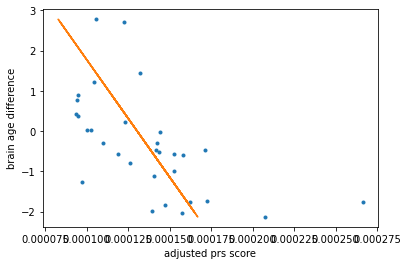

In [106]:
plt.plot(adjusted_prs_score[high_risk],brain_age_difference['residual'],'.')
lin_reg=LinearRegression()
lin_reg.fit(np.asarray(brain_age_difference['residual']).reshape(-1,1),adjusted_prs_score[high_risk])
plt.plot(lin_reg.predict(np.asarray(brain_age_difference['residual']).reshape(-1,1)),brain_age_difference['residual'])
plt.xlabel('adjusted prs score')
plt.ylabel('brain age difference')